In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import optuna
from optuna import Trial
import random
import os
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Set fixed seed
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

In [3]:
import pandas as pd

# Load the dataset
df = pd.read_csv(r'filtered_data.csv')

# Drop any unnamed columns (columns with 'Unnamed' in their name)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Convert the 'time' column to datetime
df['time'] = pd.to_datetime(df['time'], errors='coerce')

# Set the 'time' column as the index of the DataFrame
df.set_index('time', inplace=True)

# Filter the time between 5:00 and 20:00
df = df.between_time('05:00', '20:00')

# Remove any rows with negative values in numerical columns
numerical_columns = df.select_dtypes(include=['number']).columns
df = df[(df[numerical_columns] >= 0).all(axis=1)]

# View the cleaned dataset
print("First 5 rows of the cleaned dataset:")
display(df.head())

# Check for missing values in the cleaned dataset
print("Checking for missing values in the cleaned dataset:")
display(df.isnull().sum())

# Save the cleaned dataset to a new CSV file
df.to_csv('cleaned_filtered_data.csv')

First 5 rows of the cleaned dataset:


,total_solar_irradiance,direct_normal_irradiance,global_horizontal_irradiance,air_temperature,atmosphere,relative_humidity,power
time,,,,,,,
2019-01-01 05:00:00,1.0,240.0,1.0,0.5,1036.5,81.2,0.22
2019-01-01 05:15:00,1.0,240.0,1.0,0.6,1036.8,80.5,0.22
2019-01-01 05:30:00,1.0,240.0,1.0,0.7,1036.7,80.3,0.22
2019-01-01 05:45:00,1.0,240.0,1.0,0.7,1036.5,80.1,0.22
2019-01-01 06:00:00,1.0,240.0,1.0,0.7,1036.5,79.3,0.22


Cleaned dataset dimensions: (26404, 7)
Checking for missing values in the cleaned dataset:


total_solar_irradiance          0
direct_normal_irradiance        0
global_horizontal_irradiance    0
air_temperature                 0
atmosphere                      0
relative_humidity               0
power                           0
dtype: int64

In [4]:
# Define time intervals
train_start = '2019-01-01'
train_end = '2020-05-13'
val_start = '2020-05-14'
val_end = '2020-08-08'
test_start = '2020-08-09'
test_end = '2020-12-31'

# Split the data
train_df = df.loc[train_start:train_end]
val_df = df.loc[val_start:val_end]
test_df = df.loc[test_start:test_end]

# Display the shape of each split
print(f"Training set: {train_df.shape}")
print(f"Validation set: {val_df.shape}")
print(f"Test set: {test_df.shape}")

Training set: (19290, 7)
Validation set: (3141, 7)
Test set: (3973, 7)


In [5]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Select only numeric columns for scaling
numeric_columns = train_df.select_dtypes(include=[np.number]).columns

# Fit the scaler on the training set and transform it
train_scaled = scaler.fit_transform(train_df[numeric_columns])

# Apply the same scaler to validation and test sets
val_scaled = scaler.transform(val_df[numeric_columns])
test_scaled = scaler.transform(test_df[numeric_columns])

# Convert back to DataFrame with the same index and columns
train_scaled = pd.DataFrame(train_scaled, index=train_df.index, columns=numeric_columns)
val_scaled = pd.DataFrame(val_scaled, index=val_df.index, columns=numeric_columns)
test_scaled = pd.DataFrame(test_scaled, index=test_df.index, columns=numeric_columns)


In [9]:
def create_sequences(data, target_column, time_steps=54, forecast_horizon=4):
    X, y, timestamps = [], [], []
    # -time_steps - forecast_horizon + 1 to avoid going out of the DataFrame boundaries
    for i in range(len(data) - time_steps - forecast_horizon + 1):
        # Take a "window" of length time_steps
        X.append(data.iloc[i : i + time_steps].values)
        
        # Target values after forecast_horizon steps
        # Instead of just one value, we now predict the next 'forecast_horizon' values
        y.append(data.iloc[i + time_steps : i + time_steps + forecast_horizon][target_column].values)
        
        # Save the timestamp for the last predicted value in the horizon
        timestamps.append(data.index[i + time_steps + forecast_horizon - 1])
        
    return np.array(X), np.array(y), np.array(timestamps)


In [10]:
TIME_STEPS = 24  # Using the last 24 steps (6 hours) as "history"
FORECAST_HORIZON = 4  # Forecasting 4 steps ahead (1 hour, as each step is aken at 15 minute intervals)

TARGET_COLUMN = 'power'

# Creating sequences for training data
X_train, y_train, _ = create_sequences(train_scaled, TARGET_COLUMN,
                                       time_steps=TIME_STEPS,
                                       forecast_horizon=FORECAST_HORIZON)

# Creating sequences for validation data
X_val, y_val, _ = create_sequences(val_scaled, TARGET_COLUMN,
                                   time_steps=TIME_STEPS,
                                   forecast_horizon=FORECAST_HORIZON)

# Creating sequences for test data
X_test, y_test, test_timestamps = create_sequences(test_scaled, TARGET_COLUMN,
                                                   time_steps=TIME_STEPS,
                                                   forecast_horizon=FORECAST_HORIZON)

# Printing the shapes of the datasets
print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, {y_val.shape}")
print(f"Test data shape: {X_test.shape}, {y_test.shape}")


Training data shape: (19263, 24, 7), (19263, 4)
Validation data shape: (3114, 24, 7), (3114, 4)
Test data shape: (3946, 24, 7), (3946, 4)


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_model(trial, input_shape, forecast_horizon):
    # Hyperparameters to optimize
    n_layers = trial.suggest_int('n_layers', 1, 4)
    hidden_size = trial.suggest_categorical('hidden_size', [32, 64, 128, 256])  
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)    
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3) 

    model = Sequential()

    # Build the LSTM layers
    for i in range(n_layers):
        if i == 0:
            # First layer needs the input_shape
            model.add(LSTM(hidden_size, activation='relu', input_shape=input_shape, return_sequences=True if i < n_layers - 1 else False))
        else:
            model.add(LSTM(hidden_size, activation='relu', return_sequences=True if i < n_layers - 1 else False))
        model.add(Dropout(dropout_rate))

    # Output layer for multiple steps ahead (forecast horizon = 4)
    model.add(Dense(forecast_horizon))  # Predict 4 steps ahead

    # Set the Optimizer and compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mae')

    return model


In [12]:
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
import optuna

def objective(trial):
    """
    Objective function for Optuna to minimize.
    """
    forecast_horizon = 4  # Forecasting 4 steps ahead 
    input_shape = (X_train.shape[1], X_train.shape[2]) 
    
    # Build the model using the trial suggestions
    model = build_model(trial, input_shape=input_shape, forecast_horizon=forecast_horizon)
    
    # Hyperparameter for batch size
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256])
    
    # Define EarlyStopping callback to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    
    # Train the model with the chosen hyperparameters
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=batch_size, verbose=0, callbacks=[early_stopping])
    
    # Return the validation loss (which Optuna will minimize)
    val_loss = np.min(history.history['val_loss'])
    return val_loss


# Create a study with a specific name
study = optuna.create_study(study_name='LSTM_hyperparameter_optimization', direction='minimize')

# Run the optimization for 10 trials
study.optimize(objective, n_trials=10)

# Print the best hyperparameters found by Optuna
print("Best hyperparameters found: ")
print(study.best_params)


[I 2024-12-31 01:44:46,462] A new study created in memory with name: LSTM_hyperparameter_optimization


Restoring model weights from the end of the best epoch: 21.
Epoch 26: early stopping


[I 2024-12-31 01:47:36,811] Trial 0 finished with value: 0.09038162976503372 and parameters: {'n_layers': 1, 'hidden_size': 128, 'dropout_rate': 0.4227172419009241, 'learning_rate': 0.0009964772644574847, 'batch_size': 128}. Best is trial 0 with value: 0.09038162976503372.
[I 2024-12-31 01:53:12,619] Trial 1 finished with value: 0.09829304367303848 and parameters: {'n_layers': 4, 'hidden_size': 64, 'dropout_rate': 0.302930348780885, 'learning_rate': 0.0003278572826118766, 'batch_size': 128}. Best is trial 0 with value: 0.09038162976503372.


Restoring model weights from the end of the best epoch: 23.
Epoch 28: early stopping


[I 2024-12-31 01:55:05,787] Trial 2 finished with value: 0.09207386523485184 and parameters: {'n_layers': 2, 'hidden_size': 32, 'dropout_rate': 0.3141078643693734, 'learning_rate': 0.0007165435932670465, 'batch_size': 64}. Best is trial 0 with value: 0.09038162976503372.
[I 2024-12-31 01:58:56,670] Trial 3 finished with value: 0.09171179682016373 and parameters: {'n_layers': 2, 'hidden_size': 64, 'dropout_rate': 0.3915400546034259, 'learning_rate': 0.0004937747730940433, 'batch_size': 64}. Best is trial 0 with value: 0.09038162976503372.
[I 2024-12-31 02:03:00,588] Trial 4 finished with value: 0.092997245490551 and parameters: {'n_layers': 3, 'hidden_size': 64, 'dropout_rate': 0.49220427316702686, 'learning_rate': 0.000945707484416649, 'batch_size': 128}. Best is trial 0 with value: 0.09038162976503372.


Restoring model weights from the end of the best epoch: 23.
Epoch 28: early stopping


[I 2024-12-31 02:21:31,032] Trial 5 finished with value: 0.09704070538282394 and parameters: {'n_layers': 2, 'hidden_size': 256, 'dropout_rate': 0.18747385403394792, 'learning_rate': 0.00016979523257144654, 'batch_size': 256}. Best is trial 0 with value: 0.09038162976503372.


Restoring model weights from the end of the best epoch: 15.
Epoch 20: early stopping


[I 2024-12-31 03:16:44,842] Trial 6 finished with value: 0.09122679382562637 and parameters: {'n_layers': 4, 'hidden_size': 256, 'dropout_rate': 0.43191237275196326, 'learning_rate': 0.0009727431064596895, 'batch_size': 64}. Best is trial 0 with value: 0.09038162976503372.


Restoring model weights from the end of the best epoch: 18.
Epoch 23: early stopping


[I 2024-12-31 03:46:00,706] Trial 7 finished with value: 0.08933712542057037 and parameters: {'n_layers': 4, 'hidden_size': 128, 'dropout_rate': 0.15378939217044996, 'learning_rate': 0.0008995056157296568, 'batch_size': 64}. Best is trial 7 with value: 0.08933712542057037.


Restoring model weights from the end of the best epoch: 15.
Epoch 20: early stopping


[I 2024-12-31 03:48:04,478] Trial 8 finished with value: 0.09313523769378662 and parameters: {'n_layers': 2, 'hidden_size': 64, 'dropout_rate': 0.18140729314377801, 'learning_rate': 0.000817024982151808, 'batch_size': 256}. Best is trial 7 with value: 0.08933712542057037.


Restoring model weights from the end of the best epoch: 23.
Epoch 28: early stopping


[I 2024-12-31 04:17:56,949] Trial 9 finished with value: 0.09592856466770172 and parameters: {'n_layers': 3, 'hidden_size': 256, 'dropout_rate': 0.1102611095846326, 'learning_rate': 0.00016921627790346375, 'batch_size': 256}. Best is trial 7 with value: 0.08933712542057037.


Best hyperparameters found: 
{'n_layers': 4, 'hidden_size': 128, 'dropout_rate': 0.15378939217044996, 'learning_rate': 0.0008995056157296568, 'batch_size': 64}


In [13]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
import tensorflow as tf
import pandas as pd

# Combine training and validation sets
combined_scaled = pd.concat([train_scaled, val_scaled])

# Unpack three values and ignore timestamps
X_combined, y_combined, _ = create_sequences(combined_scaled, TARGET_COLUMN, time_steps=TIME_STEPS, forecast_horizon=FORECAST_HORIZON)

# Build the model with the best hyperparameters
best_params = study.best_params
model = Sequential()

for i in range(best_params['n_layers']):
    return_sequences = True if i < best_params['n_layers'] - 1 else False
    if i == 0:
        model.add(LSTM(
            best_params['hidden_size'], 
            activation='relu', 
            return_sequences=return_sequences,
            input_shape=(X_combined.shape[1], X_combined.shape[2])  # (time_steps, num_features)
        ))
    else:
        model.add(LSTM(
            best_params['hidden_size'], 
            activation='relu', 
            return_sequences=return_sequences
        ))
    model.add(Dropout(best_params['dropout_rate']))

# Add final Dense layer for forecasting 4 data points ahead 
model.add(Dense(FORECAST_HORIZON)) 

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate'])
model.compile(optimizer=optimizer, loss='mae')

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Train the model with early stopping
history = model.fit(X_combined, y_combined, epochs=30, batch_size=best_params['batch_size'], validation_split=0.2, callbacks=[early_stopping], verbose=1)



Epoch 1/30
281/281 [==============================] - 77s 258ms/step - loss: 0.1358 - val_loss: 0.1199
Epoch 2/30
281/281 [==============================] - 69s 245ms/step - loss: 0.0930 - val_loss: 0.1126
Epoch 3/30
281/281 [==============================] - 72s 255ms/step - loss: 0.0871 - val_loss: 0.1116
Epoch 4/30
281/281 [==============================] - 72s 258ms/step - loss: 0.0840 - val_loss: 0.1045
Epoch 5/30
281/281 [==============================] - 75s 267ms/step - loss: 0.0815 - val_loss: 0.1008
Epoch 6/30
281/281 [==============================] - 73s 259ms/step - loss: 0.0800 - val_loss: 0.1008
Epoch 7/30
281/281 [==============================] - 74s 263ms/step - loss: 0.0782 - val_loss: 0.1024
Epoch 8/30
281/281 [==============================] - 74s 265ms/step - loss: 0.0780 - val_loss: 0.1015
Epoch 9/30
281/281 [==============================] - 75s 267ms/step - loss: 0.0762 - val_loss: 0.1008
Epoch 10/30
281/281 [==============================] - 76s 272ms/step - l

In [14]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 24, 128)           69632     
                                                                 
 dropout_27 (Dropout)        (None, 24, 128)           0         
                                                                 
 lstm_28 (LSTM)              (None, 24, 128)           131584    
                                                                 
 dropout_28 (Dropout)        (None, 24, 128)           0         
                                                                 
 lstm_29 (LSTM)              (None, 24, 128)           131584    
                                                                 
 dropout_29 (Dropout)        (None, 24, 128)           0         
                                                                 
 lstm_30 (LSTM)              (None, 128)             

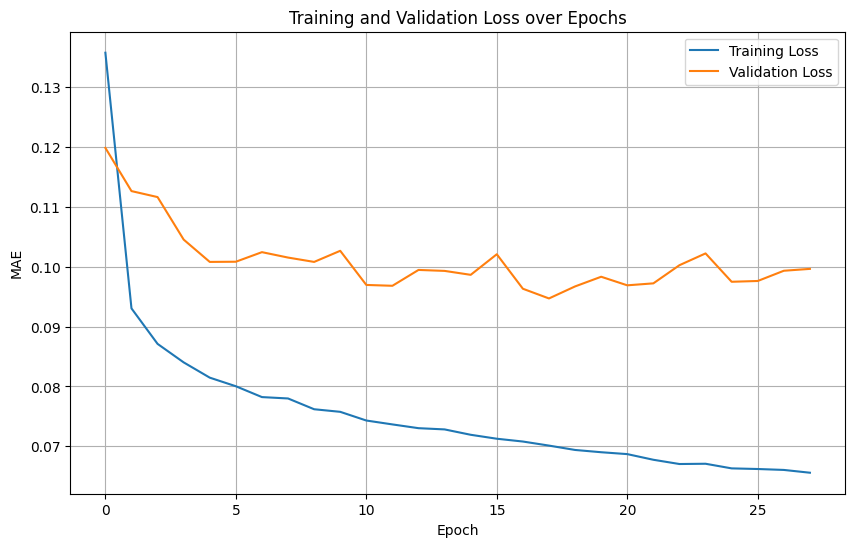

In [15]:
# Plot loss
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.savefig('training_validation_loss.png', dpi=300)
plt.show()

In [52]:
# Inverse scaling for y_pred_train (predicted values on training set)
y_pred_train = model.predict(X_train)

# Only select the predicted target values (last column)
y_pred_train_target = y_pred_train[:, -1]

# Inverse scaling only on the target values (the predicted power)
y_pred_train_inv = scaler.inverse_transform(np.column_stack([np.zeros((len(y_pred_train_target), len(numeric_columns) - 1)), y_pred_train_target]))[:, -1]

# Inverse scaling for y_val (actual values)
val_inv = scaler.inverse_transform(val_scaled)
val_inv = pd.DataFrame(val_inv, columns=numeric_columns, index=val_scaled.index)
y_val_inv = val_inv[TARGET_COLUMN].values[TIME_STEPS:]  # Skip the first TIME_STEPS values

# Inverse scaling for y_pred_val (predicted values on validation set)
y_pred_val = model.predict(X_val)

# Only select the predicted target values (last column)
y_pred_val_target = y_pred_val[:, -1]

# Inverse scaling only on the target values (the predicted power)
y_pred_val_inv = scaler.inverse_transform(np.column_stack([np.zeros((len(y_pred_val_target), len(numeric_columns) - 1)), y_pred_val_target]))[:, -1]


98/98 [==============================] - 4s 45ms/step


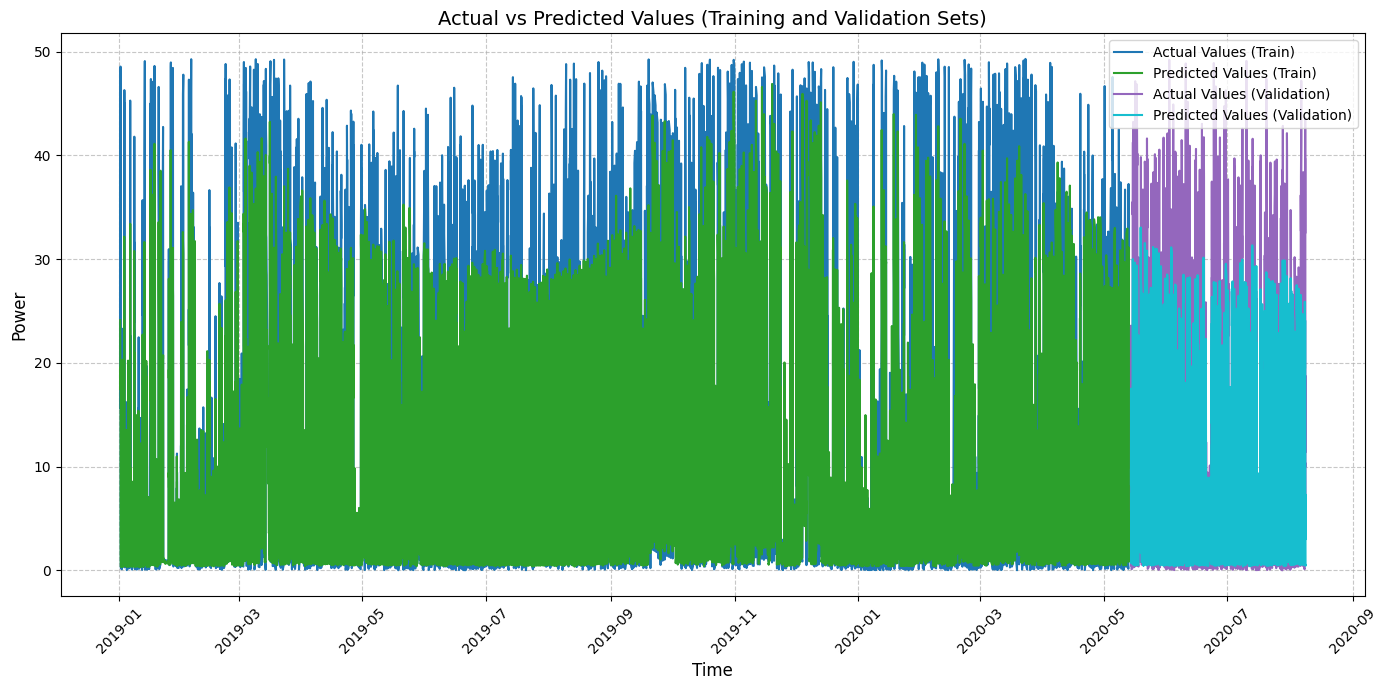

In [53]:
# Ensure that train_index and val_index have matching lengths for plotting
train_index = train_inv.index[TIME_STEPS:TIME_STEPS + len(y_pred_train_inv)]
val_index = val_inv.index[TIME_STEPS:TIME_STEPS + len(y_pred_val_inv)]

# Ensure that y_train_inv and y_val_inv are sliced properly to match the length of their respective indices
y_train_inv = y_train_inv[:len(train_index)]
y_val_inv = y_val_inv[:len(val_index)]

# Ensure y_pred_train_inv and y_pred_val_inv have matching lengths
y_pred_train_inv = y_pred_train_inv[:len(train_index)]
y_pred_val_inv = y_pred_val_inv[:len(val_index)]

# Plot Actual vs Predicted Values for Training and Validation Sets
plt.figure(figsize=(14, 7))

# Updated color palette
train_actual_color = '#1f77b4'  
train_predicted_color = '#2ca02c'  
val_actual_color = '#9467bd'  
val_predicted_color = '#17becf'

# Plot for Training Set
plt.plot(train_index, y_train_inv, label='Actual Values (Train)', color=train_actual_color)
plt.plot(train_index, y_pred_train_inv, label='Predicted Values (Train)', color=train_predicted_color)

# Plot for Validation Set
plt.plot(val_index, y_val_inv, label='Actual Values (Validation)', color=val_actual_color)
plt.plot(val_index, y_pred_val_inv, label='Predicted Values (Validation)', color=val_predicted_color)

# Add title and labels
plt.title('Actual vs Predicted Values (Training and Validation Sets)', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Power', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot with 300 DPI
plt.savefig("actual_vs_predicted_LSTM.png", dpi=300)

# Show the plot
plt.show()


In [54]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Training Set Metrics
mae_train = mean_absolute_error(y_train_inv, y_pred_train_inv)
rmse_train = np.sqrt(mean_squared_error(y_train_inv, y_pred_train_inv))
r2_train = r2_score(y_train_inv, y_pred_train_inv)

# Validation Set Metrics
mae_val = mean_absolute_error(y_val_inv, y_pred_val_inv)
rmse_val = np.sqrt(mean_squared_error(y_val_inv, y_pred_val_inv))
r2_val = r2_score(y_val_inv, y_pred_val_inv)

# Print the Results
print("Training Set Metrics:")
print(f"MAE: {mae_train:.4f}")
print(f"RMSE: {rmse_train:.4f}")
print(f"R²: {r2_train:.4f}")

print("\nValidation Set Metrics:")
print(f"MAE: {mae_val:.4f}")
print(f"RMSE: {rmse_val:.4f}")
print(f"R²: {r2_val:.4f}")


Training Set Metrics:
MAE: 4.8843
RMSE: 7.5864
R²: 0.6176

Validation Set Metrics:
MAE: 4.8559
RMSE: 6.7038
R²: 0.6345


In [55]:
# Prediction on test set
y_pred = model.predict(X_test)

# Inverse scaling for y_test (actual values)
test_inv = scaler.inverse_transform(test_scaled)
test_inv = pd.DataFrame(test_inv, columns=numeric_columns, index=test_scaled.index)

124/124 [==============================] - 6s 45ms/step


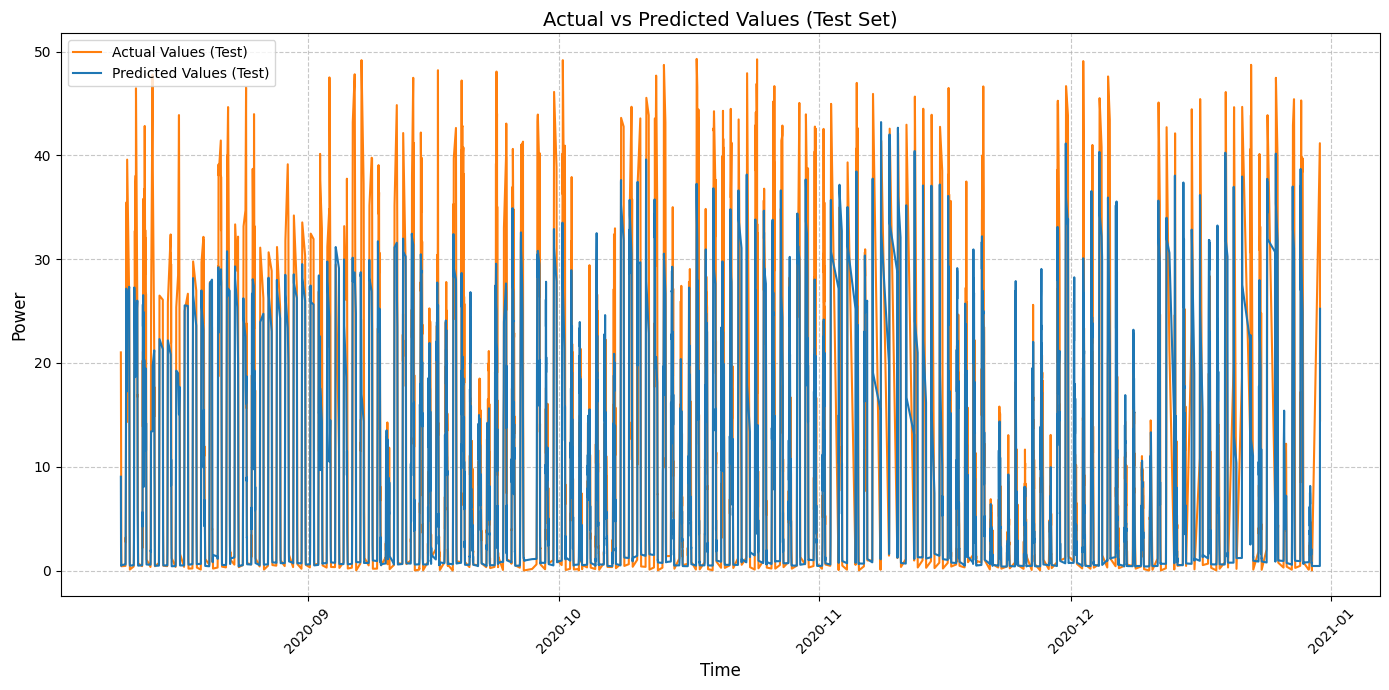

In [56]:
# Ensure that test_index, y_test_inv, and y_pred_test_inv have matching lengths for plotting
test_index = test_inv.index[TIME_STEPS:TIME_STEPS + len(y_pred_inv)]  # Align the test index
y_test_inv = y_test_inv[:len(test_index)]  # Slice actual test values to match the test index length
y_pred_inv = y_pred_inv[:len(test_index)]  # Slice predicted test values to match the test index length

# Plot Actual vs Predicted Values for Test Set
plt.figure(figsize=(14, 7))

# Updated color palette with orange and blue
test_actual_color = '#ff7f0e' 
test_predicted_color = '#1f77b4'

# Plot for Test Set
plt.plot(test_index, y_test_inv, label='Actual Values (Test)', color=test_actual_color)
plt.plot(test_index, y_pred_inv, label='Predicted Values (Test)', color=test_predicted_color)

# Add title and labels
plt.title('Actual vs Predicted Values (Test Set)', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Power', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot with 300 DPI
plt.savefig("actual_vs_predicted_test_LSTM_orange_blue.png", dpi=300)

# Show the plot
plt.show()


In [57]:
# Calculate metrics
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
#mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

# Save metrics to CSV
metrics = {
    'Timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'MAE': mae,
    'RMSE': rmse,
    'R2': r2
}

metrics_df = pd.DataFrame([metrics])
metrics_file = 'LSTM_metrics.csv'

if not os.path.isfile(metrics_file):
    metrics_df.to_csv(metrics_file, index=False)
else:
    metrics_df.to_csv(metrics_file, mode='a', header=False, index=False)

print(f"Metrics saved to {metrics_file}")


MAE: 5.62
RMSE: 8.16
R²: 0.5327
Metrics saved to LSTM_metrics.csv
